In [1]:
import torch
import torch.utils.data as data
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import time

from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter


torch.manual_seed(0)  # Reproducibility 

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# calculate dataset mean and std for normalization TODO talking point on data agumentation
# Transforms
n = 768//2 # image resize values TODO reduce image size to help reduce number of parameters.

transform = transforms.Compose([
    transforms.Resize((n, n)),
    transforms.ToTensor()
])

# Dataset and loader
dataset = datasets.ImageFolder(root='../dataset', transform=transform)

dataloader = data.DataLoader(
    dataset,
    batch_size=10,
    num_workers=1,
    shuffle=False
)

# meand and std
mean = 0.
std = 0.
nb_samples = 0.
for _, s in dataloader:
    batch_samples = _.size(0)
    _ = _.view(batch_samples, _.size(1), -1)
    mean += _.mean(2).sum(0)
    std += _.std(2).sum(0)
    nb_samples += batch_samples
mean /= nb_samples
std /= nb_samples

mean, std

(tensor([0.6703, 0.5346, 0.8518]), tensor([0.1278, 0.1731, 0.0729]))

In [4]:
# Hyperparameters
classes = ["lung_adenocarcinoma", "lung_benign_tissue", "lung_squamous_cell_carcinoma"]
batch_size = 30
n_epochs = 30
# mean, std = [0.0, 0.0, 0.0], [1.0/255.0, 1.0/255.0, 1.0/255.0] # TODO scales images between 0-1.
# mean, std = [0.6703, 0.5346, 0.8518], [0.1278, 0.1731, 0.0729]

In [5]:
# Transforms (updated)
transform = transforms.Compose([
    transforms.Resize((n, n)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Dataset
dataset = datasets.ImageFolder(root='../dataset', transform=transform)

# Splits 70, 15, 15
train_size = int(0.7 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = val_size

trainset, remdata = data.random_split(dataset, [train_size, val_size*2])
validset, testset = data.random_split(remdata, [val_size, test_size])

# DataLoaders
trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = data.DataLoader(validset, batch_size=batch_size, shuffle=True)
testloader = data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [6]:
# Split sizes
len(trainset), len(validset), len(testset)

(10500, 2250, 2250)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.7567434..2.033308].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.165036..2.033308].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.424279..2.4886942].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.316696..2.5807712].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.658875..1.9795166].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.874041..2.5807712].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.72499..2.5807

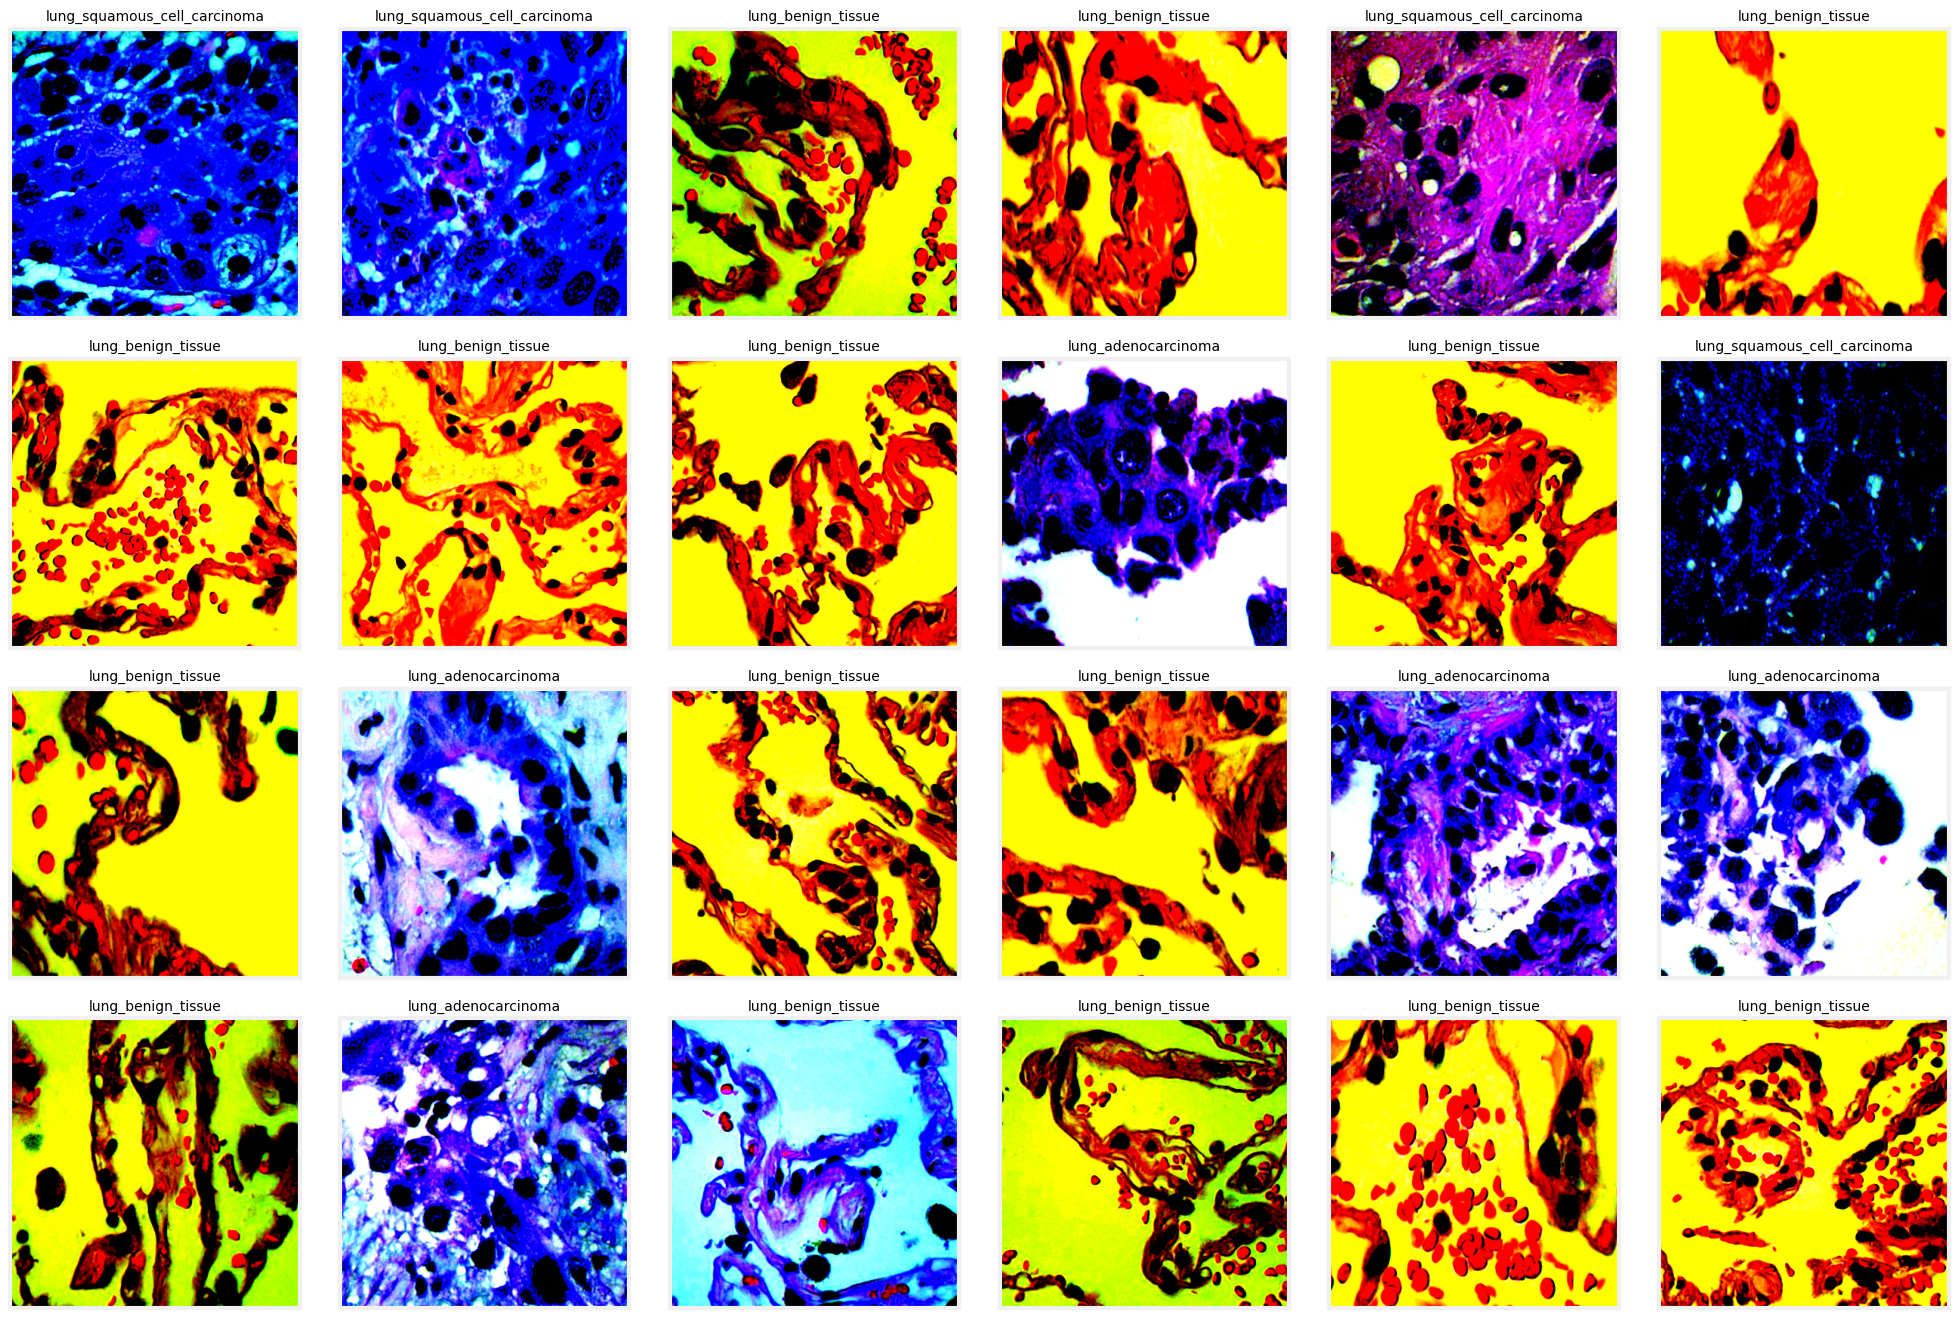

In [7]:
# Visualizations
images, labels = next(iter(trainloader))

fig = plt.figure(figsize=(20, 20))
plt.style.use("fivethirtyeight")
x, y = 6, 6
for i in range(24):
    ax = plt.subplot(y, x, i+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.set_title(f"{classes[labels[i]]}", fontsize=10)
plt.tight_layout()
# plt.savefig('original_images.png')
plt.show()

- N are lighter in color with red/pink patches making them rather easy to identify with naked eye.
- There are some similar patches to SCC and ACA, although not so prevalent

In [8]:
# plot data distribution

In [9]:
# Global average pooling can be used to reduce the dimensions of the feature maps to a single value per feature map, drastically reducing the number of parameters TODO test performance of this one.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        # fully connected layer
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, len(classes))
        # dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        return x

# create a complete CNN
model = Net()

In [10]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [11]:
# model summary
summary(model, images[0].shape, batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [30, 16, 384, 384]             448
       BatchNorm2d-2         [30, 16, 384, 384]              32
         MaxPool2d-3         [30, 16, 192, 192]               0
            Conv2d-4         [30, 32, 192, 192]           4,640
       BatchNorm2d-5         [30, 32, 192, 192]              64
         MaxPool2d-6           [30, 32, 96, 96]               0
            Conv2d-7           [30, 64, 96, 96]          18,496
       BatchNorm2d-8           [30, 64, 96, 96]             128
         MaxPool2d-9           [30, 64, 48, 48]               0
           Conv2d-10          [30, 128, 48, 48]          73,856
      BatchNorm2d-11          [30, 128, 48, 48]             256
        MaxPool2d-12          [30, 128, 24, 24]               0
           Conv2d-13          [30, 256, 24, 24]         295,168
      BatchNorm2d-14          [30, 256,

In [12]:
# visualize model
writer = SummaryWriter("logs/")
writer.add_graph(model, images.cuda())
writer.close()

# cd notebooks/logs/
# tensorboard --logdir=./

In [13]:
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
weight_decay =1e-4
optimizer = optim.Adam(model.parameters(), lr=.001, weight_decay=weight_decay) # TODO regularization

In [14]:
valid_loss_min = np.Inf # track change in validation loss
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Capture the start time
start_time = time.time()

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    correct_train = 0.0
    
    # training
    model.train()
    for data, target in trainloader:
        # move data to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients
        optimizer.zero_grad()
        # forward pass
        outputs = model(data)
        # calculate the loss
        loss = criterion(outputs, target)
        # accumulate gradients
        loss.backward()
        # update parameters
        optimizer.step()
        # store loss and accuracy for visualization
        train_loss += loss.item()*data.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == target).sum().item()
        
    # validation
    valid_loss = 0.0
    correct_valid = 0.0
    model.eval()
    for data, target in validloader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        outputs = model(data)
        loss = criterion(outputs, target)
        valid_loss += loss.item()*data.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_valid += (predicted == target).sum().item()
    
    # calculate average losses and accuracies
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(validloader.dataset)
    train_accuracy = correct_train/len(trainloader.dataset)
    valid_accuracy = correct_valid/len(validloader.dataset)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
        
    # print training/validation statistics 
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tTraining Accuracy: {train_accuracy:.6f} \tValidation Loss: {valid_loss:.6f} \tValidation Accuracy: {valid_accuracy:.6f}')
    
    # save model on loss decrease
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        
# Capture the end time
end_time = time.time()
print(f'\nTraining time: {(end_time - start_time)/60:.2f} minutes')

Epoch: 1 	Training Loss: 0.365471 	Training Accuracy: 0.868000 	Validation Loss: 0.201693 	Validation Accuracy: 0.915556
Validation loss decreased (inf --> 0.201693).  Saving model ...
Epoch: 2 	Training Loss: 0.253896 	Training Accuracy: 0.906571 	Validation Loss: 0.134823 	Validation Accuracy: 0.952889
Validation loss decreased (0.201693 --> 0.134823).  Saving model ...
Epoch: 3 	Training Loss: 0.185743 	Training Accuracy: 0.932381 	Validation Loss: 0.125715 	Validation Accuracy: 0.950667
Validation loss decreased (0.134823 --> 0.125715).  Saving model ...
Epoch: 4 	Training Loss: 0.168950 	Training Accuracy: 0.936381 	Validation Loss: 0.111417 	Validation Accuracy: 0.956000
Validation loss decreased (0.125715 --> 0.111417).  Saving model ...
Epoch: 5 	Training Loss: 0.154658 	Training Accuracy: 0.943143 	Validation Loss: 0.124195 	Validation Accuracy: 0.951556
Epoch: 6 	Training Loss: 0.139075 	Training Accuracy: 0.948381 	Validation Loss: 0.186523 	Validation Accuracy: 0.946222
Epo

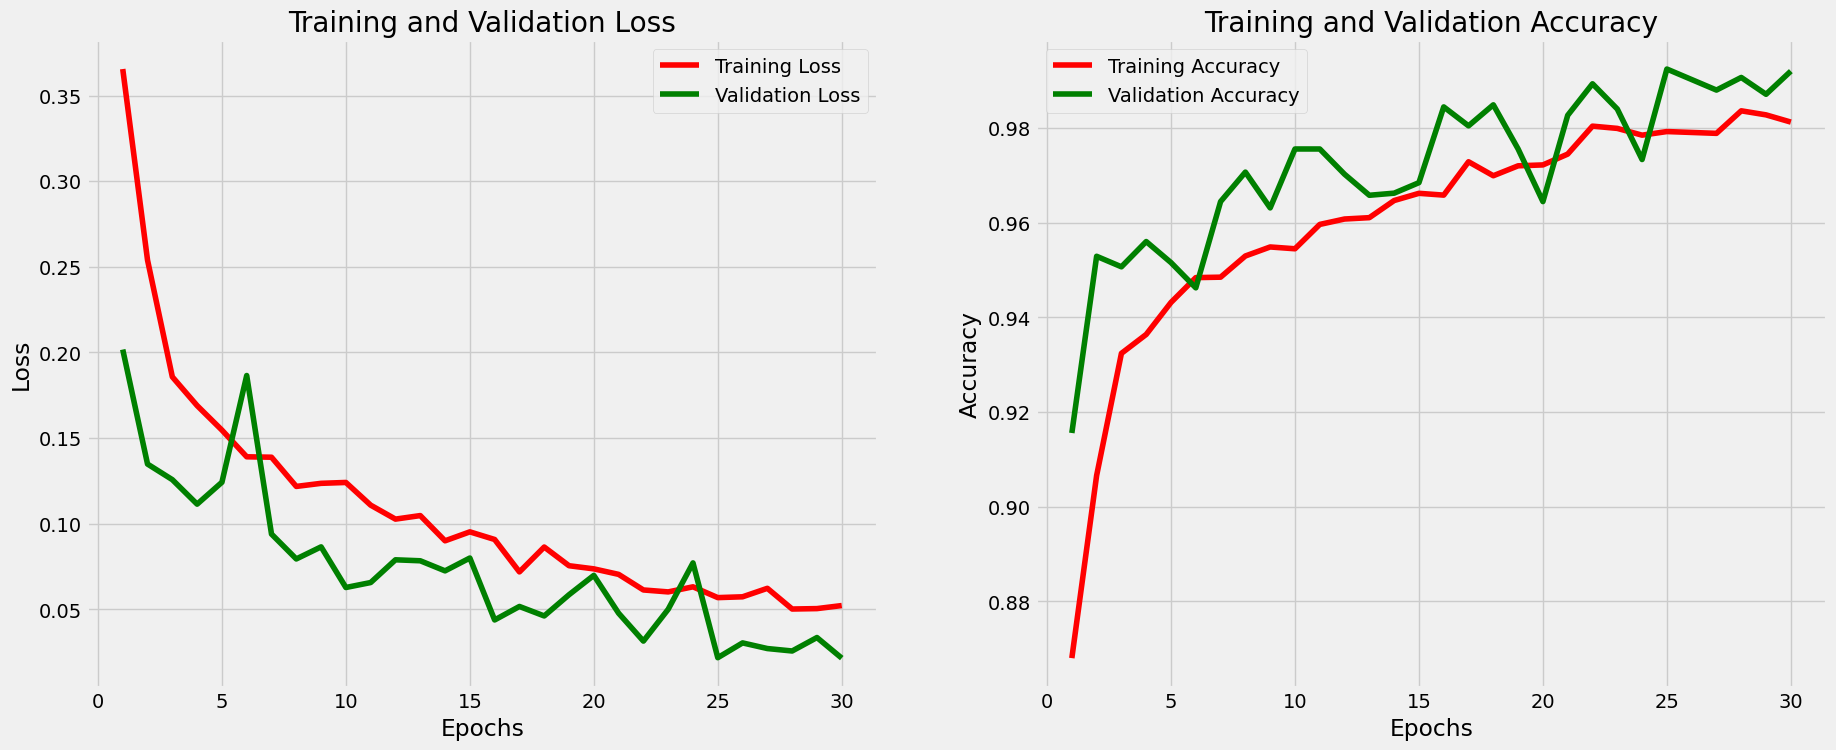

In [15]:
# performance overtime
def model_performance(train_accuracies, train_losses, validation_accuracies, validation_losses, epochs):
    # plot training history
    plt.figure(figsize=(20,8))
    plt.style.use("fivethirtyeight")

    epochs = [i+1 for i in range(epochs)]

    # losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label="Training Loss")
    plt.plot(epochs, validation_losses, 'g', label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label="Training Accuracy")
    plt.plot(epochs, validation_accuracies, 'g', label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout
    plt.show()

model_performance(train_accuracies, train_losses, valid_accuracies, valid_losses, n_epochs)

In [16]:
torch.save(model.state_dict(), 'model_all.pt')

In [17]:
# Load trained model
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [18]:
# testing
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

model.eval()
model.cpu()
for data, target in testloader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    # get predictions
    _, pred = torch.max(output, 1)    
    # compare predictions to ground truth
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate per class accuracies
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print(f'Test Loss: {test_loss:.6f}\n')

for i in range(3):
    if class_total[i] > 0:
        print(f'Test Accuracy of {classes[i]}: {(class_correct[i]/class_total[i])*100}% ({np.sum(class_correct[i])}/{np.sum(class_total[i])})')
    else:
        print(f'Test Accuracy of {classes[i]}: N/A (no training examples)')

print(f'\nTest Accuracy (Overall): {(np.sum(class_correct)/np.sum(class_total))*100} ({np.sum(class_correct)}/{np.sum(class_total)})')

Test Loss: 0.018140

Test Accuracy of lung_adenocarcinoma: 99% (716/717)
Test Accuracy of lung_benign_tissue: 100% (763/763)
Test Accuracy of lung_squamous_cell_carcinoma: 97% (753/770)

Test Accuracy (Overall): 99% (2232/2250)


# Without GAP

Test Loss: 0.134421

Test Accuracy of lung_adenocarcinoma: 93% (695/744)
Test Accuracy of lung_benign_tissue: 100% (773/773)
Test Accuracy of lung_squamous_cell_carcinoma: 92% (675/733)

Test Accuracy (Overall): 95% (2143/2250)

# With GAP
Test Loss: 0.032335

Test Accuracy of lung_adenocarcinoma: 96% (693/719)
Test Accuracy of lung_benign_tissue: 100% (760/760)
Test Accuracy of lung_squamous_cell_carcinoma: 99% (770/771)

Test Accuracy (Overall): 98% (2223/2250)